In [2]:
from torcheeg.datasets import DEAPDataset
from torcheeg import transforms
from torcheeg.datasets.constants import DEAP_CHANNEL_LIST, DEAP_LOCATION_LIST, format_channel_location_dict
from torcheeg.transforms import after_hook_normalize

(40, 40, 8064)
-36.00936535037692


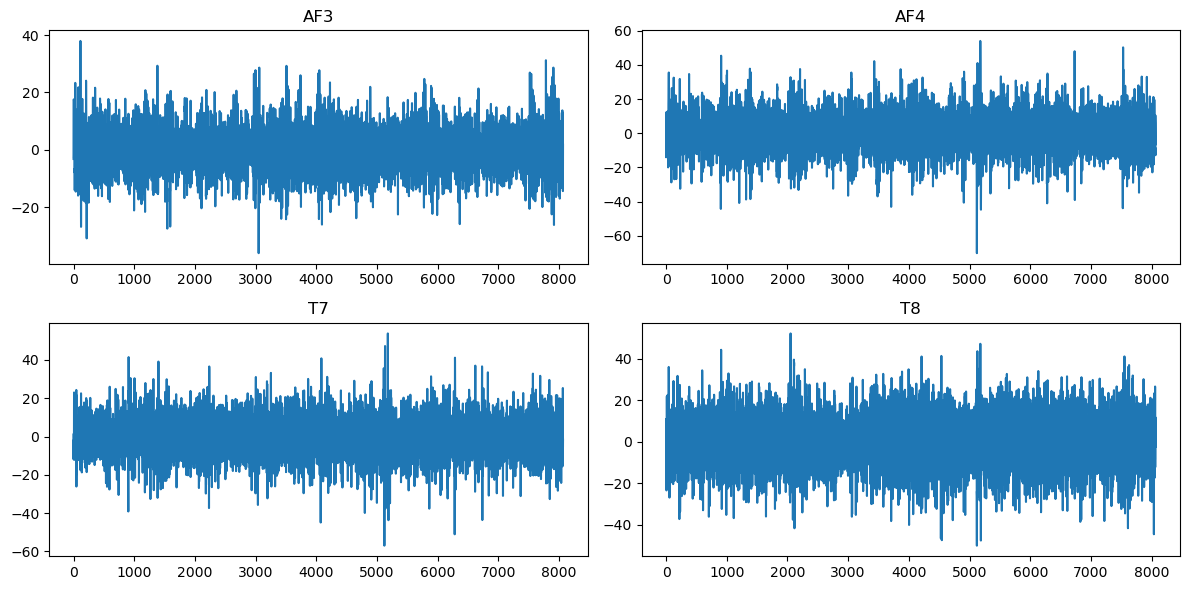

In [9]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt

sample = "/Users/andrei/Downloads/deap-dataset/data_preprocessed_python/s07.dat"
electrodes = ["AF3", "AF4", "T7", "T8"]

with open(sample, 'rb') as f:
    pkl_data = pkl.load(f, encoding='iso-8859-1')

print(pkl_data['data'].shape)
samples = pkl_data['data']
labels = pkl_data['labels']

trial = samples[0]
trial.shape

indices = transforms.PickElectrode.to_index_list(electrodes, DEAP_CHANNEL_LIST)
trial_4 = trial[indices]

print(min(trial_4[0]))
# plot
plt.figure(figsize=(12, 6))
for i, electrode in enumerate(electrodes):
    plt.subplot(2, 2, i + 1)
    plt.plot(trial_4[i])
    plt.title(electrode)
plt.tight_layout()
plt.show()

In [18]:
electrodes = ["AF3", "AF4", "T7", "T8"]
# channel_location_dict = format_channel_location_dict(electrodes, DEAP_LOCATION_LIST)
channel_location_dict = {'AF3': [0, 1], 'AF4': [0, 2], 'T7': [1, 0], 'T8': [1, 3]}



dataset = DEAPDataset(
    io_path="./temp/deap/data",
    root_path="/Users/andrei/Downloads/deap-dataset/data_preprocessed_python",
    offline_transform=transforms.Compose(
        [
            transforms.PickElectrode(
                transforms.PickElectrode.to_index_list(electrodes, DEAP_CHANNEL_LIST),
                apply_to_baseline=True,
            ),
            transforms.BaselineRemoval(),
            # transforms.RandomNoise(0.1),
            transforms.Concatenate(
                [
                    transforms.BandDifferentialEntropy(
                        sampling_rate=128
                    ),
                    transforms.BandPowerSpectralDensity(
                        sampling_rate=128
                    ),
                ]
            ),
            transforms.MeanStdNormalize(),
            transforms.ToGrid(channel_location_dict),
        ]
    ),
    online_transform=transforms.ToTensor(),
    label_transform=transforms.Compose(
        [
            transforms.Select("valence"),
            transforms.Binary(5.0),
        ]
    ),
    after_subject=after_hook_normalize,
    num_worker=8,
)

[2025-08-17 15:44:22] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./temp/deap/data.


In [80]:
x, y = dataset[0]
x.shape

torch.Size([8, 2, 4])

In [82]:
from torcheeg.model_selection import KFoldGroupbyTrial, KFoldCrossSubject

k_fold = KFoldCrossSubject(n_splits=5,
                           split_path='./temp/deap/split',
                           shuffle=True,
                           random_state=42)

channel_location_dict

{'AF3': [0, 1], 'AF4': [0, 2], 'T7': [1, 0], 'T8': [1, 3]}

In [134]:
import torch.nn as nn
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback

class TinyCCNN(nn.Module):
    def __init__(self, in_channels=8, grid_size=(2, 4), num_classes=2, dropout=0.2):
        super(TinyCCNN, self).__init__()
        self.in_channels = in_channels
        self.grid_size = grid_size
        self.num_classes = num_classes

        # Small conv backbone
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=(2,2), stride=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(1,2), stride=1),
            nn.ReLU()
        )

        # Flatten for linear layers
        self.flatten_dim = 64
        self.fc1 = nn.Sequential(
            nn.Linear(self.flatten_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

class EEGClassifier(pl.LightningModule):
    def __init__(self, model, lr=0.001, weight_decay=0):
        super().__init__()
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, logger=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

In [ ]:

import keras

# New model using resampled data
model = keras.models.Sequential()

#Convolution
model.add(keras.layers.Reshape((4, desiredSamples, 1), input_shape=(4, desiredSamples)))
model.add(keras.layers.Conv2D(32, (1, 4), strides=(1,1), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 8), strides=(1,1), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 8), strides=(1,1), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 64), strides=(1,1), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 2)))
model.add(keras.layers.Conv2D(64, (1, 8), strides=(1,1), activation='relu'))

#Dense and output
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='linear'))

model.summary()

In [ ]:
import sys
from torch.utils.data import DataLoader
from pytorch_lightning.utilities import rank_zero_info
from pytorch_lightning.loggers import CSVLogger
logger = CSVLogger("logs", name="muse2_experiment")

class PrintMetricsCallback(Callback):
    def on_epoch_end(self, trainer, pl_module):
        rank_zero_info("***** Test results *****")
        train_loss = trainer.callback_metrics.get("train_loss")
        train_acc = trainer.callback_metrics.get("train_acc")
        val_loss = trainer.callback_metrics.get("val_loss")
        val_acc = trainer.callback_metrics.get("val_acc")
        rank_zero_info(f"Epoch {trainer.current_epoch}: "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}\n")

for i, (train_dataset, val_dataset) in enumerate(k_fold.split(dataset)):
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = TinyCCNN(num_classes=2, in_channels=8, grid_size=(2, 4))

    classifier = EEGClassifier(model, lr=0.01)
    trainer = pl.Trainer(max_epochs=10, accelerator="cpu", callbacks=[PrintMetricsCallback()], logger=logger) 
    trainer.fit(classifier, train_loader, val_loader)

    score = trainer.test(
        classifier,
        val_loader,

    )[0]
    print(f'Fold {i} test accuracy: {score}')

[2025-08-17 06:10:39] INFO (torcheeg/MainThread) 📊 | Detected existing split of train and test set, use existing split from ./temp/deap/split.


[    INFO] 📊 | Detected existing split of train and test set, use existing split from ./temp/deap/split.
[    INFO] 📊 | Detected existing split of train and test set, use existing split from ./temp/deap/split.


INFO:torcheeg:📊 | Detected existing split of train and test set, use existing split from ./temp/deap/split.
[2025-08-17 06:10:39] INFO (torcheeg/MainThread) 💡 | If the dataset is re-generated, you need to re-generate the split of the dataset instead of using the previous split.


[    INFO] 💡 | If the dataset is re-generated, you need to re-generate the split of the dataset instead of using the previous split.
[    INFO] 💡 | If the dataset is re-generated, you need to re-generate the split of the dataset instead of using the previous split.


INFO:torcheeg:💡 | If the dataset is re-generated, you need to re-generate the split of the dataset instead of using the previous split.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | TinyCCNN         | 5.9 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.023     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 938/938 [00:09<00:00, 95.94it/s, v_num=1] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [00:09<00:00, 95.80it/s, v_num=1]


/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 263/263 [00:01<00:00, 149.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7285714149475098     │
│         test_loss         │    0.6338748931884766     │
└───────────────────────────┴───────────────────────────┘

Fold 0 test accuracy: {'test_loss': 0.6338748931884766, 'test_acc': 0.7285714149475098}


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:701: Checkpoint directory logs/muse2_experiment/version_1/checkpoints exists and is not empty.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | TinyCCNN         | 5.9 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
5.9 K     Trainable params


/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 938/938 [00:11<00:00, 80.94it/s, v_num=1] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [00:11<00:00, 80.90it/s, v_num=1]


/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 263/263 [00:01<00:00, 229.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7247619032859802     │
│         test_loss         │    0.6346454620361328     │
└───────────────────────────┴───────────────────────────┘

Fold 1 test accuracy: {'test_loss': 0.6346454620361328, 'test_acc': 0.7247619032859802}


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:701: Checkpoint directory logs/muse2_experiment/version_1/checkpoints exists and is not empty.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | TinyCCNN         | 5.9 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
5.9 K     Trainable params


/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 975/975 [00:11<00:00, 88.15it/s, v_num=1] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 975/975 [00:11<00:00, 88.11it/s, v_num=1]


/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 225/225 [00:01<00:00, 135.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7958333492279053     │
│         test_loss         │    0.5149601697921753     │
└───────────────────────────┴───────────────────────────┘

Fold 2 test accuracy: {'test_loss': 0.5149601697921753, 'test_acc': 0.7958333492279053}


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:701: Checkpoint directory logs/muse2_experiment/version_1/checkpoints exists and is not empty.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | TinyCCNN         | 5.9 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
5.9 K     Trainable params


/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 975/975 [00:09<00:00, 106.49it/s, v_num=1]


In [63]:
import torch 

torch.save(model.state_dict(), "./models/deap_model.pth")